In [1]:
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
import gc
from utils import *
from tqdm import tqdm
import pickle

from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.layers.core import *
from keras.layers.convolutional import *
from keras import backend as K
import tensorflow as tf

Using TensorFlow backend.


# Initialize the setting

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
random.seed(123)

class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 12 # the number of joints
        self.joint_n = 22 # the number of joints
        self.joint_d = 3 # the dimension of joints
        self.clc_coarse = 14 # the number of coarse class
        self.clc_fine = 28 # the number of fine-grained class
        self.feat_d = 231
        self.filters = 16
        self.data_dir = '/mnt/nasbi/homes/fan/projects/action/skeleton/data/SHREC/'
C = Config()

# Building the model

In [4]:
def poses_diff(x):
    H, W = x.get_shape()[1],x.get_shape()[2]
    x = tf.subtract(x[:,1:,...],x[:,:-1,...])
    x = tf.image.resize_nearest_neighbor(x,size=[H.value,W.value],align_corners=False) # should not alignment here
    return x

def pose_motion(P,frame_l):
    P_diff_slow = Lambda(lambda x: poses_diff(x))(P)
    P_diff_slow = Reshape((frame_l,-1))(P_diff_slow)
    P_fast = Lambda(lambda x: x[:,::2,...])(P)
    P_diff_fast = Lambda(lambda x: poses_diff(x))(P_fast)
    P_diff_fast = Reshape((int(frame_l/2),-1))(P_diff_fast)
    return P_diff_slow,P_diff_fast
    
def c1D(x,filters,kernel):
    x = Conv1D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def block(x,filters):
    x = c1D(x,filters,3)
    x = c1D(x,filters,3)
    return x
    
def d1D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def build_FM(frame_l=32,joint_n=22,joint_d=2,feat_d=231,filters=16):   
    M = Input(shape=(frame_l,feat_d))
    P = Input(shape=(frame_l,joint_n,joint_d))
    
    diff_slow,diff_fast = pose_motion(P,frame_l)
    
    x = c1D(M,filters*2,1)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,3)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,1)
    x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x_d_slow = c1D(diff_slow,filters*2,1)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,3)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,1)
    x_d_slow = MaxPool1D(2)(x_d_slow)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
        
    x_d_fast = c1D(diff_fast,filters*2,1)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,3) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,1) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
   
    x = concatenate([x,x_d_slow,x_d_fast])
    x = block(x,filters*2)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)
    
    x = block(x,filters*4)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x = block(x,filters*8)
    x = SpatialDropout1D(0.1)(x)
    
    return Model(inputs=[M,P],outputs=x)

In [5]:
def build_DD_Net(frame_l=32,joint_n=22,joint_d=3,feat_d=231,clc_num=14,filters=16):
    M = Input(name='M', shape=(frame_l,feat_d))  
    P = Input(name='P', shape=(frame_l,joint_n,joint_d)) 
    
    FM = build_FM(frame_l,joint_n,joint_d,feat_d,filters)
    
    x = FM([M,P])

    x = GlobalMaxPool1D()(x)
    
    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = d1D(x,128)
    x = Dropout(0.3)(x)
    x = Dense(clc_num, activation='softmax')(x)
    
    ######################Self-supervised part
    model = Model(inputs=[M,P],outputs=x)
    return model

In [6]:
DD_Net = build_DD_Net(C.frame_l,C.joint_n,C.joint_d,C.feat_d,C.clc_coarse,C.filters)

In [7]:
DD_Net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
M (InputLayer)                  (None, 32, 231)      0                                            
__________________________________________________________________________________________________
P (InputLayer)                  (None, 32, 22, 3)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 4, 128)       119392      M[0][0]                          
                                                                 P[0][0]                          
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 128)          0           model_1[1][0]                    
__________

## load data

In [8]:
Train = pickle.load(open(C.data_dir+"train.pkl", "rb"))
Test = pickle.load(open(C.data_dir+"test.pkl", "rb"))

## Without frame_sampling train

In [ ]:
X_0 = []
X_1 = []
Y = []
for i in tqdm(range(len(Train['pose']))): 
    p = np.copy(Train['pose'][i]).reshape([-1,22,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Train['coarse_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_0.append(M)
    X_1.append(p)
    Y.append(label)

X_0 = np.stack(X_0)  
X_1 = np.stack(X_1) 
Y = np.stack(Y)

In [ ]:
X_test_0 = []
X_test_1 = []
Y_test = []
for i in tqdm(range(len(Test['pose']))): 
    p = np.copy(Test['pose'][i]).reshape([-1,22,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Test['coarse_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_test_0.append(M)
    X_test_1.append(p)
    Y_test.append(label)

X_test_0 = np.stack(X_test_0) 
X_test_1 = np.stack(X_test_1)  
Y_test = np.stack(Y_test)

In [11]:
import keras
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=400,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test)      
                    )

Train on 1960 samples, validate on 840 samples
Epoch 1/400
1960/1960 [==============================] - 10s 5ms/step - loss: 3.1060 - acc: 0.0704 - val_loss: 2.5793 - val_acc: 0.0881
Epoch 2/400
1960/1960 [==============================] - 1s 342us/step - loss: 2.9880 - acc: 0.0740 - val_loss: 2.5032 - val_acc: 0.1345
Epoch 3/400
1960/1960 [==============================] - 1s 582us/step - loss: 2.8850 - acc: 0.0985 - val_loss: 2.4300 - val_acc: 0.1869
Epoch 4/400
1960/1960 [==============================] - 1s 337us/step - loss: 2.8036 - acc: 0.1224 - val_loss: 2.3587 - val_acc: 0.2250
Epoch 5/400
1960/1960 [==============================] - 1s 565us/step - loss: 2.7350 - acc: 0.1347 - val_loss: 2.2959 - val_acc: 0.2512
Epoch 6/400
1960/1960 [==============================] - 1s 324us/step - loss: 2.6217 - acc: 0.1495 - val_loss: 2.2379 - val_acc: 0.2667
Epoch 7/400
1960/1960 [==============================] - 1s 528us/step - loss: 2.5688 - acc: 0.1510 - val_loss: 2.1850 - val_acc: 0.

Epoch 61/400
1960/1960 [==============================] - 1s 287us/step - loss: 0.6277 - acc: 0.7974 - val_loss: 0.7238 - val_acc: 0.7548
Epoch 62/400
1960/1960 [==============================] - 0s 220us/step - loss: 0.6337 - acc: 0.8194 - val_loss: 0.7230 - val_acc: 0.7476
Epoch 63/400
1960/1960 [==============================] - 1s 271us/step - loss: 0.6308 - acc: 0.8010 - val_loss: 0.7266 - val_acc: 0.7464
Epoch 64/400
1960/1960 [==============================] - 1s 261us/step - loss: 0.6057 - acc: 0.8184 - val_loss: 0.7330 - val_acc: 0.7440
Epoch 65/400
1960/1960 [==============================] - 1s 326us/step - loss: 0.5823 - acc: 0.8342 - val_loss: 0.7359 - val_acc: 0.7524
Epoch 66/400
1960/1960 [==============================] - 0s 255us/step - loss: 0.5690 - acc: 0.8286 - val_loss: 0.7339 - val_acc: 0.7500
Epoch 67/400
1960/1960 [==============================] - 1s 357us/step - loss: 0.5613 - acc: 0.8398 - val_loss: 0.7269 - val_acc: 0.7524
Epoch 68/400
1960/1960 [==========

Epoch 121/400
1960/1960 [==============================] - 1s 474us/step - loss: 0.2227 - acc: 0.9372 - val_loss: 0.3498 - val_acc: 0.8893
Epoch 122/400
1960/1960 [==============================] - 1s 420us/step - loss: 0.2174 - acc: 0.9357 - val_loss: 0.3444 - val_acc: 0.8881
Epoch 123/400
1960/1960 [==============================] - 1s 473us/step - loss: 0.2124 - acc: 0.9413 - val_loss: 0.3387 - val_acc: 0.8940
Epoch 124/400
1960/1960 [==============================] - 1s 367us/step - loss: 0.2034 - acc: 0.9469 - val_loss: 0.3337 - val_acc: 0.8952
Epoch 125/400
1960/1960 [==============================] - 1s 540us/step - loss: 0.2156 - acc: 0.9372 - val_loss: 0.3322 - val_acc: 0.8940
Epoch 126/400
1960/1960 [==============================] - 1s 352us/step - loss: 0.2028 - acc: 0.9444 - val_loss: 0.3333 - val_acc: 0.8940
Epoch 127/400
1960/1960 [==============================] - 1s 529us/step - loss: 0.2207 - acc: 0.9388 - val_loss: 0.3308 - val_acc: 0.8940
Epoch 128/400
1960/1960 [==

Epoch 180/400
1960/1960 [==============================] - 1s 404us/step - loss: 0.1293 - acc: 0.9643 - val_loss: 0.2831 - val_acc: 0.9167
Epoch 181/400
1960/1960 [==============================] - 1s 527us/step - loss: 0.1257 - acc: 0.9663 - val_loss: 0.2823 - val_acc: 0.9167
Epoch 182/400
1960/1960 [==============================] - 1s 370us/step - loss: 0.1278 - acc: 0.9628 - val_loss: 0.2813 - val_acc: 0.9167
Epoch 183/400
1960/1960 [==============================] - 1s 515us/step - loss: 0.1293 - acc: 0.9638 - val_loss: 0.2798 - val_acc: 0.9179
Epoch 184/400
1960/1960 [==============================] - 1s 414us/step - loss: 0.1267 - acc: 0.9658 - val_loss: 0.2773 - val_acc: 0.9155
Epoch 185/400
1960/1960 [==============================] - 1s 516us/step - loss: 0.1158 - acc: 0.9684 - val_loss: 0.2748 - val_acc: 0.9155
Epoch 186/400
1960/1960 [==============================] - 1s 340us/step - loss: 0.1209 - acc: 0.9694 - val_loss: 0.2721 - val_acc: 0.9202
Epoch 187/400
1960/1960 [==

Epoch 239/400
1960/1960 [==============================] - 1s 488us/step - loss: 0.1168 - acc: 0.9684 - val_loss: 0.2298 - val_acc: 0.9369
Epoch 240/400
1960/1960 [==============================] - 1s 307us/step - loss: 0.1297 - acc: 0.9592 - val_loss: 0.2295 - val_acc: 0.9369
Epoch 241/400
1960/1960 [==============================] - 1s 433us/step - loss: 0.1129 - acc: 0.9709 - val_loss: 0.2293 - val_acc: 0.9369
Epoch 242/400
1960/1960 [==============================] - 1s 337us/step - loss: 0.1050 - acc: 0.9724 - val_loss: 0.2290 - val_acc: 0.9369
Epoch 243/400
1960/1960 [==============================] - 1s 459us/step - loss: 0.1028 - acc: 0.9735 - val_loss: 0.2287 - val_acc: 0.9369
Epoch 244/400
1960/1960 [==============================] - 1s 354us/step - loss: 0.1110 - acc: 0.9709 - val_loss: 0.2285 - val_acc: 0.9369
Epoch 245/400
1960/1960 [==============================] - 1s 517us/step - loss: 0.1082 - acc: 0.9704 - val_loss: 0.2282 - val_acc: 0.9369
Epoch 246/400
1960/1960 [==

Epoch 298/400
1960/1960 [==============================] - 1s 357us/step - loss: 0.1110 - acc: 0.9719 - val_loss: 0.2220 - val_acc: 0.9381
Epoch 299/400
1960/1960 [==============================] - 1s 438us/step - loss: 0.1066 - acc: 0.9709 - val_loss: 0.2220 - val_acc: 0.9393
Epoch 300/400
1960/1960 [==============================] - 1s 375us/step - loss: 0.1081 - acc: 0.9673 - val_loss: 0.2219 - val_acc: 0.9393
Epoch 301/400
1960/1960 [==============================] - 1s 451us/step - loss: 0.1072 - acc: 0.9745 - val_loss: 0.2219 - val_acc: 0.9393
Epoch 302/400
1960/1960 [==============================] - 1s 401us/step - loss: 0.1060 - acc: 0.9638 - val_loss: 0.2218 - val_acc: 0.9393
Epoch 303/400
1960/1960 [==============================] - 1s 473us/step - loss: 0.0932 - acc: 0.9745 - val_loss: 0.2218 - val_acc: 0.9405
Epoch 304/400
1960/1960 [==============================] - 1s 383us/step - loss: 0.1092 - acc: 0.9755 - val_loss: 0.2218 - val_acc: 0.9405
Epoch 305/400
1960/1960 [==

Epoch 357/400
1960/1960 [==============================] - 1s 465us/step - loss: 0.1080 - acc: 0.9689 - val_loss: 0.2206 - val_acc: 0.9405
Epoch 358/400
1960/1960 [==============================] - 1s 329us/step - loss: 0.1142 - acc: 0.9709 - val_loss: 0.2206 - val_acc: 0.9405
Epoch 359/400
1960/1960 [==============================] - 1s 479us/step - loss: 0.1088 - acc: 0.9668 - val_loss: 0.2206 - val_acc: 0.9405
Epoch 360/400
1960/1960 [==============================] - 1s 362us/step - loss: 0.1097 - acc: 0.9694 - val_loss: 0.2205 - val_acc: 0.9405
Epoch 361/400
1960/1960 [==============================] - 1s 447us/step - loss: 0.1160 - acc: 0.9668 - val_loss: 0.2205 - val_acc: 0.9405
Epoch 362/400
1960/1960 [==============================] - 1s 417us/step - loss: 0.1170 - acc: 0.9735 - val_loss: 0.2204 - val_acc: 0.9405
Epoch 363/400
1960/1960 [==============================] - 1s 404us/step - loss: 0.1076 - acc: 0.9735 - val_loss: 0.2204 - val_acc: 0.9405
Epoch 364/400
1960/1960 [==

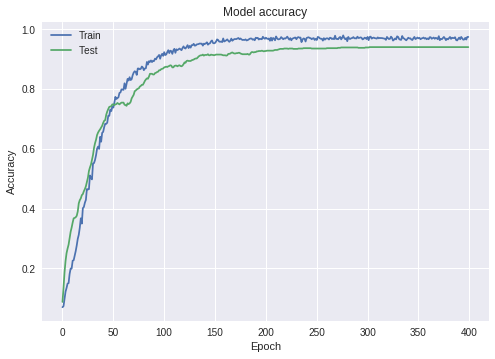

In [12]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [9]:
DD_Net.save_weights('weights/coarse_lite.h5')

## With frame_sampling

In [16]:
lr = 1e-5
DD_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])

In [ ]:
epochs = 20
for e in range(epochs):
    print('epoch{}'.format(e))
    X_0 = []
    X_1 = []
    Y = []
    
    for i in tqdm(range(len(Train['pose']))): 

        label = np.zeros(C.clc_coarse)
        label[Train['coarse_label'][i]-1] = 1 
        
        p = np.copy(Train['pose'][i]).reshape([-1,22,3])
        p = sampling_frame(p,C)
        
        M = get_CG(p,C)
        
        X_0.append(M)
        X_1.append(p)
        Y.append(label)

    X_0 = np.stack(X_0)  
    X_1 = np.stack(X_1) 
    Y = np.stack(Y)
   

    DD_Net.fit([X_0,X_1],Y,
            batch_size=len(Y),
            epochs=1,
            verbose=True,
            shuffle=True,
            validation_data=([X_test_0,X_test_1],Y_test)      
            )



# Calculate time (excute it twice, the first time initialize takes extra times)

In [ ]:
import time
start_time = time.time()
y = DD_Net.predict([X_0,X_1])
time.time() - start_time

# Plot confusion matrix

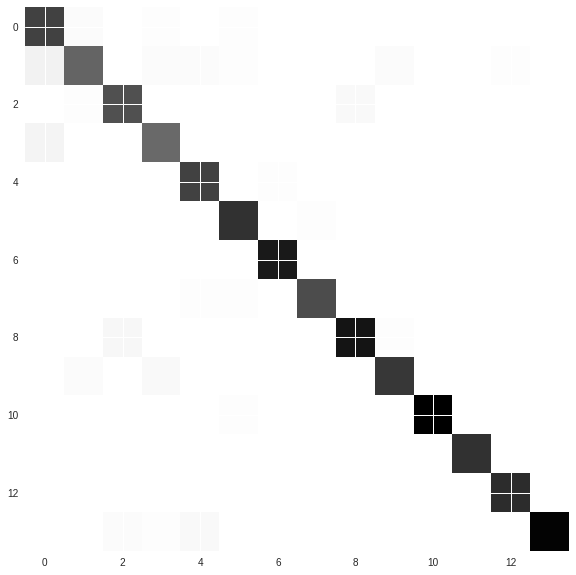

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

Y_pred = DD_Net.predict([X_test_0,X_test_1])
cnf_matrix = confusion_matrix(np.argmax(Y_test,axis=1),np.argmax(Y_pred,axis=1))
plt.figure(figsize=(10,10))
plt.imshow(cnf_matrix)
plt.show()